In [1]:
import os
import cv2
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import optimizers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

Using TensorFlow backend.


In [2]:
train = pd.read_csv('../input/train.csv')
labels = pd.read_csv('../input/labels.csv')
test = pd.read_csv('../input/sample_submission.csv')

print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
print('Number of labels: ', labels.shape[0])
display(train.head())
display(labels.head())

train["id"] = train["id"].apply(lambda x:x+".png")
test["id"] = test["id"].apply(lambda x:x+".png")

Number of train samples:  109237
Number of test samples:  7443
Number of labels:  1103


,id,attribute_ids
0,1000483014d91860,147 616 813
1,1000fe2e667721fe,51 616 734 813
2,1001614cb89646ee,776
3,10041eb49b297c08,51 671 698 813 1092
4,100501c227f8beea,13 404 492 903 1093


,attribute_id,attribute_name
0,0,culture::abruzzi
1,1,culture::achaemenid
2,2,culture::aegean
3,3,culture::afghan
4,4,culture::after british


### Model

In [3]:
# Model parameters
BATCH_SIZE = 64
EPOCHS = 45
LEARNING_RATE = 0.0001
HEIGHT = 64
WIDTH = 64
CANAL = 3
N_CLASSES = labels.shape[0]
classes = list(map(str, range(N_CLASSES)))

In [4]:
train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/train",
    x_col="id",
    y_col="attribute_ids",
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",
    classes=classes,
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/train",
    x_col="id",
    y_col="attribute_ids",
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",    
    classes=classes,
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "../input/test",    
        x_col="id",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 3460 images belonging to 1103 classes.
Found 864 images belonging to 1103 classes.
Found 7443 images.


In [5]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(HEIGHT, WIDTH, CANAL)))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(N_CLASSES, activation="sigmoid"))

optimizer = optimizers.adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",metrics=["accuracy", "categorical_accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=valid_generator,
                                validation_steps=STEP_SIZE_VALID,
                                epochs=EPOCHS,
                                verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/45
 - 27s - loss: 0.2210 - acc: 0.9015 - categorical_accuracy: 0.0026 - val_loss: 0.0095 - val_acc: 0.9991 - val_categorical_accuracy: 0.0577
Epoch 2/45
 - 18s - loss: 0.0129 - acc: 0.9982 - categorical_accuracy: 0.0101 - val_loss: 0.0074 - val_acc: 0.9991 - val_categorical_accuracy: 0.0850
Epoch 3/45
 - 18s - loss: 0.0108 - acc: 0.9986 - categorical_accuracy: 0.0142 - val_loss: 0.0069 - val_acc: 0.9991 - val_categorical_accuracy: 0.0925
Epoch 4/45
 - 18s - loss: 0.0096 - acc: 0.9988 - categorical_accuracy: 0.0159 - val_loss: 0.0065 - val_acc: 0.9991 - val_categorical_accuracy: 0.1163
Epoch 5/45
 - 18s - loss: 0.0087 - acc: 0.9989 - categorical_accuracy: 0.0213 - val_loss: 0.0062 - val_acc: 0.9991 - val_categorical_accuracy: 0.0587
Epoch 6/45
 - 18s - loss: 0.0082 - acc: 0.9989 - categorical_accuracy: 0.0214 - val_loss: 0.0063 - val_acc: 0.9991 - val_categorical_accuracy: 0.0838
Epoch 7/45
 - 18s - loss: 0.0077 - acc: 0.9990 - cat

### Model graph loss

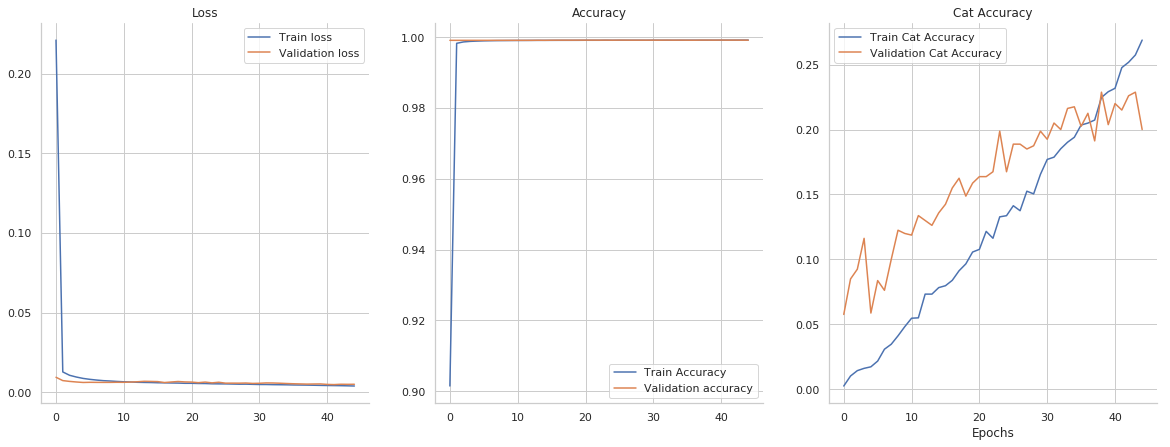

In [7]:
sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(20,7))


ax1.plot(history.history['loss'], label='Train loss')
ax1.plot(history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history.history['acc'], label='Train Accuracy')
ax2.plot(history.history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

ax3.plot(history.history['categorical_accuracy'], label='Train Cat Accuracy')
ax3.plot(history.history['val_categorical_accuracy'], label='Validation Cat Accuracy')
ax3.legend(loc='best')
ax3.set_title('Cat Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

### Apply model to test set and output predictions

In [8]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)

In [9]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

predictions = []
for pred_ar in preds:
    valid = ''
    for idx, pred in enumerate(pred_ar):
        if pred > 0.28:
            if len(valid) == 0:
                valid += labels[idx]
            else:
                valid += (' %s' % labels[idx])
    if len(valid) == 0:
        valid = np.argmax(pred_ar)
    predictions.append(valid)

In [10]:
filenames = test_generator.filenames
results = pd.DataFrame({'id':filenames, 'attribute_ids':predictions})
results['id'] = results['id'].map(lambda x: str(x)[:-4])
results.to_csv('submission.csv',index=False)
results.head(10)

,id,attribute_ids
0,10023b2cc4ed5f68,129
1,100fbe75ed8fd887,68
2,101b627524a04f19,897
3,10234480c41284c6,54
4,1023b0e2636dcea8,68
5,1039cd6cf85845c,1092
6,103a5b3f83fbe88,54
7,10413aaae8d6a9a2,54
8,10423822b93a65ab,551
9,1052bf702cb099f7,744
